# SNP/Phenotype detection from raw text

In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cPickle, os, sys
np.random.seed(seed=1701)
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# import snorkel and gwasdb
sys.path.append('../snorkel')
sys.path.append('../src')

# set up paths
abstract_dir = '../data/db/papers'

## Assemble a corpus

Collect all the tables in our dataset

In [26]:
from snorkel.parser import XMLDocParser
from extractor.parser import UnicodeXMLTableDocParser

xml_parser = UnicodeXMLTableDocParser(
    path=abstract_dir,
    doc='./*',
    text='.//table',
    id='.//article-id[@pub-id-type="pmid"]/text()',
    keep_xml_tree=True)

In [27]:
import lxml.etree as et
with open('../data/db/papers/19305408.xml') as f:
    for i,doc in enumerate(et.parse(f).xpath('./*')):
        print doc
#         print et.tostring(doc.xpath('.//table')[0])
#         print doc.xpath('.//table')
#         print '\n'.join([et.tostring(elem) for elem in doc.xpath('.//table') if elem is not None])

<Element article at 0x10a5a4a00>


In [28]:
from snorkel.parser import HTMLParser
from extractor.parser import UnicodeTableParser
from snorkel.parser import CorpusParser
import cPickle

table_parser = UnicodeTableParser()
html_parser = HTMLParser(path='../data/db/papers/')

corpus_name = 'gwas-table-corpus.pkl'

try:
    with open(corpus_name,"r") as pkl:
        corpus = cPickle.load(pkl)
except:
    cp = CorpusParser(xml_parser, table_parser, max_docs=15)
    %time corpus = cp.parse_corpus(name='GWAS Corpus')
    # pickling currently doesn't work...
#     with open(corpus_name,"w") as pkl:
#         corpus = cPickle.dump(corpus, pkl)

CPU times: user 53.1 s, sys: 2.91 s, total: 56 s
Wall time: 1min 20s


In [6]:
# pickling currently doesn't work...
# import cPickle
# with open(corpus_name,"w") as pkl:
#     corpus = cPickle.dump(corpus, pkl)

In [7]:
print corpus.documents[0]

Document('17447842', Corpus (GWAS Corpus))


In [8]:
for cell in corpus.get_tables()[97].cells:
#     print cell.row_num , cell.col_num, cell.text
    pass

IndexError: list index out of range

In [ ]:
print corpus.get_tables()[100].document

In [ ]:
from snorkel.models import Context
context = Context()
print context.id

## Try extracting rs-ids first

In [29]:
# add new paths
sys.path.append('../src/crawler')
sys.path.append('../src/crawler/db')

# import new libs
from kb import KnowledgeBase
from extractor.util import gold_rsid_stats, gold_rsid_precision

from snorkel.candidates import Ngrams
from snorkel.matchers import DictionaryMatch, RegexMatchSpan, Union
from snorkel.candidates import EntityExtractor

# from snorkel.candidates import Candidates

### Create a gold set

Get a list of all the rs-ids we know.

In [30]:
kb = KnowledgeBase()

In [31]:
rs_ids = kb.get_rsid_candidates()
print rs_ids[0]

rs4950928


Get a gold set:

In [32]:
gold_set = frozenset( [ (doc.name, rs_id) for doc in corpus.documents for rs_id in kb.rsids_by_pmid(int(doc.name)) ] )
gold_set_rsids = [rs_id for doc_id, rs_id in gold_set]

In [33]:
gold_rsid_dict = {doc_id : set() for doc_id, rs_id in gold_set}
for docid, rsid in gold_set:
    gold_rsid_dict[docid].add(rsid)

In [34]:
print len(gold_set)

178


### Extract candidates:

In [45]:
from snorkel.candidates import EntityExtractor
from snorkel.candidates import TableNgrams

# Define a candidate space
ngrams = TableNgrams(n_max=1)

# Define matchers
dict_rsid_matcher = DictionaryMatch(d=rs_ids, longest_match_only=False)
gold_rsid_matcher = DictionaryMatch(d=gold_set_rsids, longest_match_only=False)
regx_rsid_matcher = RegexMatchSpan(rgx=r'rs\d+')
rsid_matcher = Union(dict_rsid_matcher, regx_rsid_matcher)

rsid_extractor = EntityExtractor(ngrams, rsid_matcher)
%time rs_candidates = rsid_extractor.extract(corpus.get_tables(), name='all')

# # collect candidates
# %time gold_dict_c = Candidates(ngrams, gold_rsid_matcher, corpus.get_contexts())
# %time rsid_c = Candidates(ngrams, rsid_matcher, corpus.get_contexts())

CPU times: user 1.06 s, sys: 36.7 ms, total: 1.1 s
Wall time: 1.08 s


In [46]:
for cand in rs_candidates[:10]: 
    print cand
print "%s candidates extracted" % len(rs_candidates)
print rs_candidates[0].context
print rs_candidates[0].context.cell

Span("rs2076756", context=None, chars=[0,8], words=[0,0])
Span("rs1992662", context=None, chars=[0,8], words=[0,0])
Span("rs1992660", context=None, chars=[0,8], words=[0,0])
Span("rs1793004", context=None, chars=[0,8], words=[0,0])
Span("rs10521209", context=None, chars=[0,9], words=[0,0])
Span("rs2631372", context=None, chars=[0,8], words=[0,0])
Span("rs2925757", context=None, chars=[0,8], words=[0,0])
Span("rs6947579", context=None, chars=[0,8], words=[0,0])
Span("rs1553575", context=None, chars=[0,8], words=[0,0])
Span("rs10484545", context=None, chars=[0,9], words=[0,0])
1577 candidates extracted
Phrase('17684544', 1, 20, 0, u'rs2076756')
Cell('17684544', 1, 20, u'rs2076756')


### Statistics

Statistics on all the rsid candidates:

In [17]:
gold_rsid_stats(rs_candidates, gold_set)

# of gold annotations	= 178
# of candidates		= 1371
Candidate recall	= 0.978
Candidate precision	= 0.127


Interesting: some SNPs seem to be never mentioned (e.g. rs12122100) while others (rs727153) appear only in the text.

Sometimes, it's not picked up for a different, strange reason: see rs13314993.

In [18]:
from extractor.util import gold_rsid_recall

incorrect_rsids = list(gold_rsid_recall(rs_candidates, gold_set))
for ngram in incorrect_rsids[:10]:
    print ngram

('17447842', 'rs11209026')
('17447842', 'rs1373692')
('17658951', 'rs9930506')
('17447842', 'rs5743289')


In [19]:
from extractor.util import gold_rsid_precision

strange_ngrams = list(gold_rsid_precision(rs_candidates, gold_set))
for ngram in strange_ngrams[70:100]:
    print ngram.context

Phrase('17903292', 1, 371, 0, u'rs295136')
Phrase('17903292', 1, 389, 0, u'rs754958')
Phrase('17903292', 1, 396, 0, u'rs10495487')
Phrase('17903292', 1, 403, 0, u'rs10489578')
Phrase('17903292', 1, 410, 0, u'rs10515134')
Phrase('17903292', 1, 417, 0, u'rs10489578')
Phrase('17903292', 1, 424, 0, u'rs10484370')
Phrase('17903292', 1, 431, 0, u'rs10511176')
Phrase('17903292', 1, 438, 0, u'rs10502302')
Phrase('17903292', 2, 9, 0, u'rs2839235')
Phrase('17903292', 2, 16, 0, u'rs10512437')
Phrase('17903292', 2, 23, 0, u'rs2480555')
Phrase('17903292', 2, 30, 0, u'rs10486135')
Phrase('17903292', 2, 37, 0, u'rs727087')
Phrase('17903292', 2, 44, 0, u'rs1005066')
Phrase('17903292', 2, 51, 0, u'rs2885618')
Phrase('17903292', 2, 58, 0, u'rs10496887')
Phrase('17903292', 2, 72, 0, u'rs10485409')
Phrase('17903292', 2, 86, 0, u'rs10502192')
Phrase('17903292', 2, 93, 0, u'rs2077678')
Phrase('17903292', 2, 100, 0, u'rs723464')
Phrase('17903292', 2, 107, 0, u'rs9305355')
Phrase('17903292', 2, 114, 0, u'rs10

In [20]:
gold_rsid_dict['17903292']

{'rs10499559', 'rs1158167', 'rs1712790', 'rs6977660', 'rs9305354', 'rs9322817'}

## Get candidate p-values

Need to use regular expressions for this.

In [47]:
from extractor.matcher import PvalMatcher
rgx1 = u'[1-9]\d?[\xb7\.]?\d*\s*[\xd7\*]\s*10\s*[-\u2212\u2013]\s*\d+'
pval_rgx_matcher1 = RegexMatchSpan(rgx=rgx1)
rgx2 = u'[1-9]\d?[\xb7\.]?\d*\s*[eE][-\u2212\u2013]\d+'
pval_rgx_matcher2 = RegexMatchSpan(rgx=rgx2)
rgx3 = u'0\.0000+\d+'
pval_rgx_matcher3 = RegexMatchSpan(rgx=rgx3)
pval_matcher = Union(pval_rgx_matcher1, pval_rgx_matcher2, pval_rgx_matcher3)
# pval_matcher = PvalMatcher()
ngrams = TableNgrams(n_max=7)
pval_extractor = EntityExtractor(ngrams, pval_matcher)
%time pval_c = pval_extractor.extract(corpus.get_tables(), name='all')

CPU times: user 2.04 s, sys: 45.9 ms, total: 2.08 s
Wall time: 2.07 s


In [48]:
ngrams = TableNgrams(n_max=7)

print 'Got %d candidates, e.g.:' % len(pval_c)
for candidate in pval_c[:10]:
    print unicode(candidate)
    print candidate.context
#     for t in ngrams.apply(candidate.context):
#         print unicode(t.get_span())
#         print re.match(rgx, t.get_span())
#     print [unicode(t.get_span()) for t in ngrams.apply(candidate.context)]
#     print
#     print candidate.get_attrib_span('words')
    print

Got 1246 candidates, e.g.:
Span("1.93E-13", context=None, chars=[0,7], words=[0,0])
Phrase('17684544', 1, 26, 0, u'1.93E-13')

Span("2.04E-12", context=None, chars=[0,7], words=[0,0])
Phrase('17684544', 1, 27, 0, u'2.04E-12')

Span("6.80E-20", context=None, chars=[0,7], words=[0,0])
Phrase('17684544', 1, 31, 0, u'6.80E-20')

Span("1.39E-21", context=None, chars=[0,7], words=[0,0])
Phrase('17684544', 1, 32, 0, u'1.39E-21')

Span("5.90E-08", context=None, chars=[0,7], words=[0,0])
Phrase('17684544', 1, 34, 0, u'5.90E-08')

Span("7.59E-05", context=None, chars=[0,7], words=[0,0])
Phrase('17684544', 1, 47, 0, u'7.59E-05')

Span("4.53E-05", context=None, chars=[0,7], words=[0,0])
Phrase('17684544', 1, 63, 0, u'4.53E-05')

Span("8.65E-05", context=None, chars=[0,7], words=[0,0])
Phrase('17684544', 1, 95, 0, u'8.65E-05')

Span("8.68E-05", context=None, chars=[0,7], words=[0,0])
Phrase('17684544', 1, 96, 0, u'8.68E-05')

Span("1.68E-06", context=None, chars=[0,7], words=[0,0])
Phrase('17684544

In [23]:
for ngram in pval_c:
    if ngram.context.document.name == '19096518':
        print str(ngram.context.cell)

Filter nested p-value estimates e.g. 1.2\*10^-7 and 2*10^-7

In [24]:
# load existing candidates into a dict
span_dict = { str(span.context.cell) : list() for span in pval_c }
for span in pval_c:
    span_dict[str(span.context.cell)].append( (span.char_start, span.char_end) )

def nested(ivl1, ivl2):
    if ivl1 != ivl2 and ivl2[0] <= ivl1[0] <= ivl1[1] <= ivl2[1]:
        return True
    else:
        return False

new_pval_c = list()
for span in pval_c:
    span_ivl = span.char_start, span.char_end
    span_name = str(span.context.cell)
    if all([not nested(span_ivl, other_ivl) for other_ivl in span_dict[span_name]]):
        new_pval_c.append(span)
#     else:
#         print span_ivl, span_dict[span_name]
#         print unicode(span)
#         print unicode(span.context.cell.text)
#         print span.uid
#         print span.context.row_num, span.context.col_num
#         print unicode(span)
#         print
#         print [(cell, cell.row_num, cell.col_num) for cell in span.context.table.cells]
#         break

print len(new_pval_c), len(pval_c)
pval_c = new_pval_c

1246 1246


### Statistics

First, how many p-values that should be present do we extract?

In [25]:
# we need to define a p-value -> float converter
from extractor.util import pvalue_to_float, gold_pval_stats, gold_pval_precision

print pvalue_to_float(u"6.2×10 −5")
print pvalue_to_float(u"1.85×10 −20")

6.2e-05
1.85e-20


In [26]:
from kb import KnowledgeBase
kb = KnowledgeBase()
gold_set_pvals = frozenset([ (doc.name, pval) for doc in corpus.documents for pval in kb.pvals_by_pmid(int(doc.name)) ])
gold_set_dict = {doc.name: kb.assoc_by_pmid(int(doc.name)) for doc in corpus.documents }

We will be looking at precision/recall over p-values that are known to be associated with a SNP, and the rsid of that SNP occurs somewhere in the document (as determined above).

In [27]:
from extractor.util import gold_pval_stats, gold_pval_stats_limited

print 'Found %d gold mentions, e.g.:' % len(gold_set_pvals)
print list(gold_set_pvals)[:5]
print

print 'p-value candidate extraction statistics:'
# print gold_pval_stats(pval_c, gold_set_pvals, gold_set_dict)
print gold_pval_stats_limited(pval_c, gold_set_dict, rs_candidates)

Found 107 gold mentions, e.g.:
[('17903300', 1e-07), ('17903300', 2e-07), ('17903294', 2e-06), ('17903296', 2e-07), ('17903303', 4.9999999999999996e-06)]

p-value candidate extraction statistics:
[('17684544', 1e-21), ('17684544', 4e-07), ('17684544', 3e-06), ('17903292', 9.000000000000001e-09), ('17903292', 2e-06), ('17903292', 4e-06), ('17903292', 7e-06), ('17903292', 8e-06), ('17903293', 1e-14), ('17903293', 4e-12)]
[('17684544', -21.0), ('17684544', -7.0), ('17684544', -6.0), ('17903292', -9.0), ('17903292', -6.0), ('17903293', -14.0), ('17903293', -12.0), ('17903293', -8.0), ('17903293', -7.0), ('17903293', -6.0)]
[('17684544', -49.0), ('17684544', -41.0), ('17684544', -34.0), ('17684544', -28.0), ('17684544', -22.0), ('17684544', -21.0), ('17684544', -20.0), ('17684544', -18.0), ('17684544', -17.0), ('17684544', -14.0)]
# of gold annotations	= 35
# of candidates		= 78
Candidate recall	= 0.886
Candidate precision	= 0.397
None


Some debugging... We will print the papers and their pvalues that are not found in the paper. Below, is the list of all SNPs associated with the paper, so we can find the SNP that is missing.

In [28]:
from extractor.util import gold_pval_recall, gold_pval_precision
missing = list(gold_pval_recall(pval_c, gold_set_dict, rs_candidates))
# print gold_pval_precision(pval_c, gold_set_pvals)

In [29]:
from math import log10, floor

for pmid, pval in missing[:5]:
    print pmid, pval
    print [(a.pvalue, a.phenotype.name, floor(log10(a.pvalue)), a.snp.rs_id) for a in gold_set_dict[pmid]]
    print

17903298 -8.0
[(2e-06, u'Diabetes related insulin traits', -6.0, u'rs2877832'), (3e-06, u'Diabetes related insulin traits', -6.0, u'rs2877832'), (2e-08, u'Fasting plasma glucose', -8.0, u'rs2722425'), (4.9999999999999996e-06, u'Fasting plasma glucose', -6.0, u'rs10510634'), (7e-07, u'Diabetes (incident)', -7.0, u'rs10497721'), (8e-06, u'Diabetes related insulin traits', -6.0, u'rs10486607'), (9e-06, u'Diabetes related insulin traits', -6.0, u'rs2066219'), (4.9999999999999996e-06, u'Fasting plasma glucose', -6.0, u'rs180730'), (6e-06, u'Fasting plasma glucose', -6.0, u'rs180730'), (9e-06, u'Fasting plasma glucose', -6.0, u'rs2722425'), (7e-06, u'Fasting plasma glucose', -6.0, u'rs7731657')]

17903302 -9.0
[(2e-06, u'Blood pressure', -6.0, u'rs10493340'), (3e-06, u'Blood pressure', -6.0, u'rs1963982'), (3e-06, u'Blood pressure', -6.0, u'rs935334'), (2e-06, u'Tonometry', -6.0, u'rs6063312'), (3e-06, u'Tonometry', -6.0, u'rs770189'), (6e-06, u'Tonometry', -6.0, u'rs10514688'), (6e-06, u'To

The SNPs above are either labeled incorrectly (most of the time), or could also not occur in tables.

## Extract candidate relations between SNPs and p-values

In [49]:
from snorkel.candidates import AlignedTableRelationExtractor
# Relation Extractor:
relation_extractor = AlignedTableRelationExtractor(rsid_extractor, pval_extractor)

In [50]:
%time candidates = relation_extractor.extract(corpus.get_tables(), name='all')

for cand in candidates[:10]: 
    print cand
print "%s relations extracted" % len(candidates)

CPU times: user 58.5 s, sys: 514 ms, total: 59 s
Wall time: 59.2 s
SpanPair(Span("rs2076756", context=None, chars=[0,8], words=[0,0]), Span("1.93E-13", context=None, chars=[0,7], words=[0,0]))
SpanPair(Span("rs2076756", context=None, chars=[0,8], words=[0,0]), Span("2.04E-12", context=None, chars=[0,7], words=[0,0]))
SpanPair(Span("rs2076756", context=None, chars=[0,8], words=[0,0]), Span("6.80E-20", context=None, chars=[0,7], words=[0,0]))
SpanPair(Span("rs2076756", context=None, chars=[0,8], words=[0,0]), Span("1.39E-21", context=None, chars=[0,7], words=[0,0]))
SpanPair(Span("rs2076756", context=None, chars=[0,8], words=[0,0]), Span("5.90E-08", context=None, chars=[0,7], words=[0,0]))
SpanPair(Span("rs1992662", context=None, chars=[0,8], words=[0,0]), Span("7.59E-05", context=None, chars=[0,7], words=[0,0]))
SpanPair(Span("rs1992660", context=None, chars=[0,8], words=[0,0]), Span("4.53E-05", context=None, chars=[0,7], words=[0,0]))
SpanPair(Span("rs10521209", context=None, chars=[0,

In [52]:
print candidates[1000].span0.context.cell.row_num
print candidates[1000].span1.context.cell.row_num

63
63


In [86]:
# candidates_bak = candidates

### Statistics

Let's consider the subset of gold SNPs that have been found to match somewhere with a table.

In [53]:
rs_subset = set([span.get_span().lower() for span in rs_candidates])
print list(rs_subset)[:5]

[u'rs10484246', u'rs7865184', u'rs633082', u'rs667463', u'rs2105819']


In [54]:
gold_relations = set([(assoc.snp.rs_id, assoc.pvalue) for doc in corpus.documents for assoc in kb.assoc_by_pmid(doc.name) if assoc.snp.rs_id.lower() in rs_subset])
print list(gold_relations)[:5]
print len(gold_relations)

[(u'rs10493485', 2e-06), (u'rs7042864', 6e-06), (u'rs2066219', 9e-06), (u'rs958672', 2e-06), (u'rs10489849', 1e-06)]
178


In [55]:
kb.assoc_by_pmid(18483556)[10].pvalue

2e-24

In [56]:
from extractor.util import gold_rspval_stats

gold_rspval_stats(candidates, gold_relations)

# of gold annotations	= 176
# of candidates		= 1091
Candidate recall	= 0.932
Candidate precision	= 0.150


## Learning the rsid/pvalue relation

### Load the gold set

In [57]:
from extractor.util import get_exponent, pvalue_to_float

gold_relations = set([(assoc.snp.rs_id, assoc.pvalue) for doc in corpus.documents for assoc in kb.assoc_by_pmid(doc.name) if assoc.snp.rs_id.lower() in rs_subset])
gold_relations = set([ (rs_id, get_exponent(pval)) for rs_id, pval in gold_relations ])

In [58]:
gt_dict_pos = dict()
gt_dict_neg = dict()
for crel in candidates:
    if (crel.span0.get_span(), get_exponent(pvalue_to_float(crel.span1.get_span()))) in gold_relations:
        gt_dict_pos[crel.uid] = +1
    else:
        gt_dict_neg[crel.uid] = -1

print len(gt_dict_pos), len(gt_dict_neg)
gt_dict = dict(gt_dict_pos.items() + gt_dict_neg.items())

180 1046


In [59]:
len(gt_dict)

1226

### Load the features

Extract features, and store them to a file.

In [60]:
from snorkel.features import TableNgramPairFeaturizer

pkl_f = 'phenotype_feats.pkl'
try:
    with open(pkl_f, 'rb') as f:
        featurizer = cPickle.load(f)
except:
    featurizer = TableNgramPairFeaturizer()
    featurizer.fit_transform(candidates)

Building feature index...
5 feature generators in total.
0/1226
0/1226
0/1226
0/1226
0/1226
Extracting features...
0/25480
5000/25480
10000/25480
15000/25480
20000/25480
25000/25480


In [61]:
for f in featurizer.get_features_by_candidate(candidates[0])[:10]: print f

e0_DDLIB_WORD_SEQ_[rs2076756]
e0_DDLIB_LEMMA_SEQ_[rs2076756]
e0_DDLIB_POS_SEQ_[NN]
e0_DDLIB_DEP_SEQ_[ROOT]
e0_DDLIB_W_LEFT_1_[rs2076756]
e0_DDLIB_W_LEFT_POS_1_[NN]
e0_DDLIB_NUM_WORDS_1
e0_TABLE_ROW_NUM_[2]
e0_TABLE_COL_NUM_[1]
e0_TABLE_HTML_TAG_td


In [62]:
pkl_f = 'rsid_pval_feats.pkl'
with open(pkl_f, 'w+') as f:
    cPickle.dump(featurizer, f)

Split into training and test sets

In [63]:
# Split into train and test set
training_candidates = []
gold_candidates     = []
gold_labels         = []
n_half = len(candidates)/2
for c in candidates[:n_half]:
    if c.uid in gt_dict:
        gold_candidates.append(c)
        gold_labels.append(gt_dict[c.uid])
    else:
        training_candidates.append(c)
training_candidates.extend(candidates[n_half:])
gold_labels = np.array(gold_labels)
print "Training set size: %s" % len(training_candidates)
print "Gold set size: %s" % len(gold_candidates)
print "Positive labels in training set: %s" % len([c for c in training_candidates if gt_dict.get(c.uid,0)==1])
print "Negative labels in training set: %s" % len([c for c in training_candidates if gt_dict.get(c.uid,0)==-1])
print "Positive labels in gold set: %s" % len([c for c in gold_candidates if gt_dict[c.uid]==1])
print "Negative labels in gold set: %s" % len([c for c in gold_candidates if gt_dict[c.uid]==-1])

Training set size: 613
Gold set size: 613
Positive labels in training set: 76
Negative labels in training set: 537
Positive labels in gold set: 104
Negative labels in gold set: 509


Create the model.

### Labeling functions

In [64]:
rsid_keywords = ["id", "rsid", "snp"]
pval_keywords = ["value", "p-value", "p-val", "p_value", "pvalue"]

# positive LFs
def LF_pval_header(m):
    # if "pvalue" is mentioned in first or last row, it's probably correct
    pass
def LF_pval_aligned(m):
    # if "pvalue" is mentioned in aligned cells, it's probably correct
    return +1 if any(kw in m.span1.aligned_ngrams('words') for kw in pval_keywords) else 0
def LF_id_aligned(m):
    # if "id" is mentioned in aligned cells, it's probably correct    
    return +1 if any(kw in m.span0.aligned_ngrams('words') for kw in rsid_keywords) else 0
def LF_phen_aligned(m):
    # if there is an aligned phenotype, then it is probably correct
    pass

# negative LFs
def LF_align(m):
    # if the two spans don't align in the table, then they're clearly wrong    
    return -1 if m.span0.context.row_num != m.span1.context.row_num and \
                 m.span0.context.col_num != m.span1.context.col_num \
              else 0
def LF_diff_col(m):
    return -1 if m.span0.context.col_num != m.span1.context.col_num else 0

pos_LFs = [LF_pval_aligned, LF_id_aligned]
neg_LFs = [LF_align]
LFs = pos_LFs + neg_LFs

In [65]:
from snorkel.snorkel import TrainingSet
from snorkel.features import NgramFeaturizer

training_set = TrainingSet(training_candidates, LFs, featurizer=TableNgramPairFeaturizer())

/Library/Python/2.7/site-packages/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Applying LFs...
Featurizing...
Building feature index...
5 feature generators in total.
0/613
0/613
0/613
0/613
0/613
Extracting features...
0/13819
5000/13819
10000/13819
LF Summary Statistics: 3 LFs applied to 613 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		100.00%
Overlap (candidates w/ > 1 labels):		90.05%
Conflict (candidates w/ conflicting labels):	0.00%


#### Results

In [66]:
lf_stats = training_set.lf_stats()
lf_stats[:5]

,conflicts,coverage,j,overlaps
LF_pval_aligned,0,0.900489,0,0.900489
LF_id_aligned,0,1.000000,1,0.900489
LF_align,0,0.000000,2,0.000000


array([[<matplotlib.axes.AxesSubplot object at 0x1133f2a90>]], dtype=object)

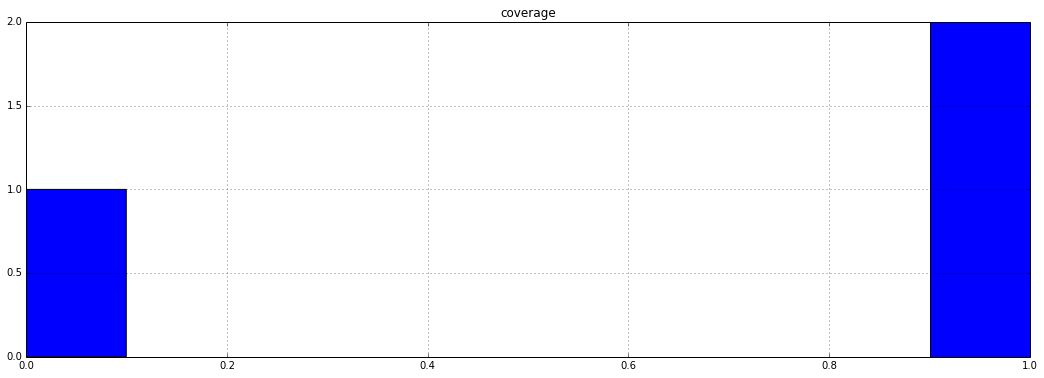

In [67]:
lf_stats.hist("coverage")

In [75]:
from snorkel.snorkel import Learner
from snorkel.learning import LogReg

learner = Learner(training_set, model=LogReg(bias_term=True))

In [76]:
# Splitting into CV and test set
n_half = len(gold_candidates)/2
test_candidates = gold_candidates[:n_half]
test_labels     = gold_labels[:n_half]
cv_candidates   = gold_candidates[n_half:]
cv_labels       = gold_labels[n_half:]

In [77]:
from snorkel.learning_utils import GridSearch

gs       = GridSearch(learner, ['mu', 'lf_w0'], [[1e-5, 1e-7],[1.0,2.0]])
gs_stats = gs.fit(cv_candidates, cv_labels)

Testing mu = 1.00e-05, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.053487
	Learning epoch = 250	Gradient mag. = 0.100755
	Learning epoch = 500	Gradient mag. = 0.175007
	Learning epoch = 750	Gradient mag. = 0.277700
Final gradient magnitude for rate=0.01, mu=1e-05: 0.299
Applying LFs...
Featurizing...
Testing mu = 1.00e-05, lf_w0 = 2.00e+00
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.102728
	Learning epoch = 250	Gradient mag. = 0.189344
	Learning epoch = 500	Gradient mag. = 0.298607
	Learning epoch = 750	Gradient mag. = 0.297986
Final gradient magnitude for rate=0.01, mu=1e-05: 0.296
Testing mu = 1.00e-07, lf_w0 = 1.00e+00
Begin training for rate=0.01, mu=1e-07
	Learning epoch = 0	Gradient mag. = 0.053487
	Learning epoch = 250	Gradient mag. = 0.100882
	Learning epoch = 500	Gradient mag. = 0.175328
	Learning epoch = 750	Gradient mag. = 0.278068
Final gradient magnitude for rate=0.01, mu=1e-07: 0.299
Testin

In [78]:
gs_stats

,mu,lf_w0,Prec.,Rec.,F1
0,0.00001,1,0.14658,1,0.255682
1,0.00001,2,0.14658,1,0.255682
2,0.00000,1,0.14658,1,0.255682
3,0.00000,2,0.14658,1,0.255682


Applying LFs...
Featurizing...


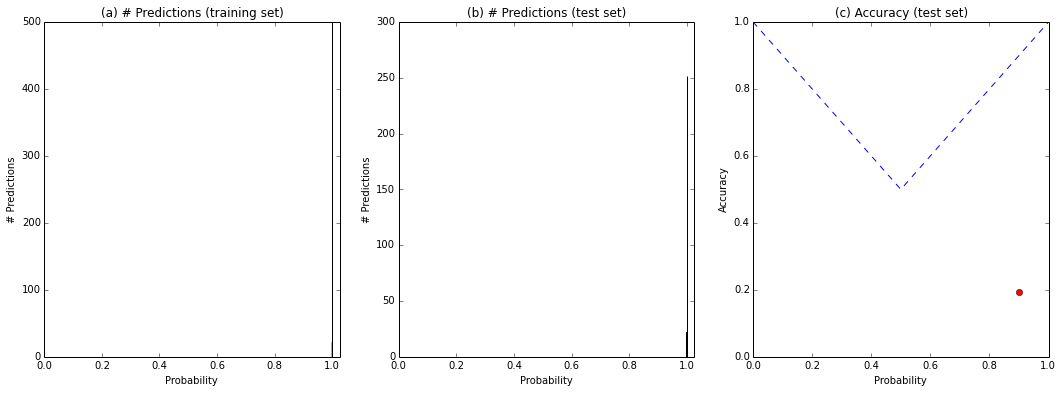

Test set size:	306
----------------------------------------
Precision:	0.192810457516
Recall:		1.0
F1 Score:	0.323287671233
----------------------------------------
TP: 59 | FP: 247 | TN: 0 | FN: 0


In [79]:
learner.test(test_candidates, test_labels)

In [80]:
learner.feature_stats(n_max=10)

,j,w
e0_TABLE_HTML_ANC_TAG_tr,4076,0.227713
e0_TABLE_HTML_ANC_TAG_table,3747,0.227713
e0_TABLE_COL_WORDS_snp,7557,0.227713
e0_TABLE_HTML_ANC_TAG_body,7628,0.227713
e1_TABLE_HTML_ANC_TAG_body,2686,0.227713
e0_TABLE_HTML_ANC_ATTR_frame=hsides,13201,0.227713
e0_TABLE_HTML_TAG_td,2602,0.227713
e1_DDLIB_W_LEFT_1_[_NUMBER],8142,0.227713
e1_TABLE_HTML_ANC_ATTR_rules=groups,5376,0.227713
e0_TABLE_HTML_ANC_ATTR_rules=groups,8868,0.227713


In [103]:
mislabeled_cand = learner.mislabeled_test_candidates(test_candidates, test_labels)
for (c,p,g) in mislabeled_cand[50:500]:
    snp_name = c.span0.get_span()
    if snp_name not in gold_rel_dict: continue
    print c.span0.context.document.name
    print c.span0.context    
    print c.span1.context
    print

17903292
Phrase('17903292', 2, 65, 0, u'rs1712790')
Phrase('17903292', 2, 68, 0, u'9.1*10 -07')

17903292
Phrase('17903292', 2, 79, 0, u'rs9305354')
Phrase('17903292', 2, 82, 0, u'1.9*10 -05')

17903292
Phrase('17903292', 2, 121, 0, u'rs6977660')
Phrase('17903292', 2, 124, 0, u'1.6*10 -05')

17903292
Phrase('17903292', 2, 135, 0, u'rs10499559')
Phrase('17903292', 2, 138, 0, u'2.8*10 -05')

17903292
Phrase('17903292', 2, 142, 0, u'rs9322817')
Phrase('17903292', 2, 145, 0, u'7.4*10 -05')

17903293
Phrase('17903293', 1, 11, 0, u'rs2494250')
Phrase('17903293', 1, 15, 0, u'3.5*10 -8')

17903293
Phrase('17903293', 1, 19, 0, u'rs4128725')
Phrase('17903293', 1, 23, 0, u'3.3*10 -8')

17903293
Phrase('17903293', 1, 27, 0, u'rs2794520')
Phrase('17903293', 1, 31, 0, u'4.3*10 -5')

17903293
Phrase('17903293', 1, 43, 0, u'rs2794520')
Phrase('17903293', 1, 46, 0, u'1.3*10 -7')

17903293
Phrase('17903293', 1, 43, 0, u'rs2794520')
Phrase('17903293', 1, 47, 0, u'3.9*10 -4')

17903293
Phrase('17903293', 

In [92]:
gold_rel_dict = dict(gold_relations)

In [97]:
gold_rel_dict

{u'rs1031381': -6.0,
 u'rs10483853': -6.0,
 u'rs10484128': -6.0,
 u'rs10484246': -8.0,
 u'rs10485165': -6.0,
 u'rs10486607': -6.0,
 u'rs10488172': -6.0,
 u'rs10488360': -6.0,
 u'rs10489087': -6.0,
 u'rs10489849': -6.0,
 u'rs10489896': -6.0,
 u'rs10491334': -6.0,
 u'rs10492096': -6.0,
 u'rs10492681': -6.0,
 u'rs10493340': -6.0,
 u'rs10493389': -6.0,
 u'rs10493485': -6.0,
 u'rs10496262': -7.0,
 u'rs10496265': -8.0,
 u'rs10497721': -7.0,
 u'rs10498091': -6.0,
 u'rs10499559': -6.0,
 u'rs10501920': -6.0,
 u'rs10503887': -7.0,
 u'rs10504543': -6.0,
 u'rs10506458': -6.0,
 u'rs10506701': -6.0,
 u'rs10506821': -7.0,
 u'rs10507130': -6.0,
 u'rs10507577': -6.0,
 u'rs10510628': -6.0,
 u'rs10510634': -6.0,
 u'rs10514345': -7.0,
 u'rs10514688': -6.0,
 u'rs10515148': -7.0,
 u'rs10518765': -6.0,
 u'rs10521232': -6.0,
 u'rs1079596': -6.0,
 u'rs1106683': -7.0,
 u'rs1106684': -6.0,
 u'rs1119582': -6.0,
 u'rs11209026': -18.0,
 u'rs1155865': -6.0,
 u'rs1158167': -9.0,
 u'rs1160297': -6.0,
 u'rs1200821': -6